## Train Infection Classifier

In the previous lessons we have built a method for cell instance segmentation and applied it to our dataset. Now we turn to classifying the cells into infected vs. non-infected cells, based on the virus marker channel, nucleus image channel and segmentation mask for each individual cell. We will use a ResNet for this task.

The goal of this lesson is to learn how to train a classification model with `torch_em`.

In [136]:
# General imports.

import itertools
import json
import os
import sys
import time
from glob import glob

import imageio.v3 as imageio
import matplotlib.pyplot as plt
import napari
import numpy as np

sys.path.append("..")
import utils

In [4]:
# This function will download and unpack the data and do some further data preparation.
# It will only be executed if the data has not been downloaded already.
data_dir = "../data"
if os.path.exists(data_dir):
    print("The data is downloaded already.")
else:
    utils.prepare_data(data_dir)

The data is downloaded already.


In [61]:
# The data has been downloaded and separated into folders for the train, validation and test split already.
# We first create a dictionary with the location of the three different split folders.
data_dirs = {
    "train": os.path.join(data_dir, "train"),
    "val": os.path.join(data_dir, "val"),
    "test": os.path.join(data_dir, "test")
}

# And check the content for one of the samples.
# You should see the images (marker, nuclei, serum), labels (cells and nuclei) as well as a json file.
train_sample0 = os.path.join(data_dirs["train"], "gt_image_000")
print(os.listdir(train_sample0))

['labels.json', 'gt_image_000_marker_image.tif', 'gt_image_000_cell_labels.tif', 'gt_image_000_nucleus_labels.tif', 'gt_image_000_serum_image.tif', 'gt_image_000_infected_labels.tif', 'gt_image_000_nucleus_image.tif']


### 1. Inspect Training Data

We check the training data for one of the images. The task we will solve is classifying the cells into infected and non-infected cells.
To this end we cut out small images containing only the cells around each cell. We then us three channels as input to the neural network for classification:
- The marker channel, which indicates the infection.
- The nucleus channel, in order to locate the signal w.r.t. the nucleus.
- And the binary cell mask.

We DO NOT use the serum channel here.

All the information for extracting these labels is present already, we now check it for the first training sample.

In [19]:
# The file paths for the images of the first training sample.
marker_path = os.path.join(train_sample0, "gt_image_000_marker_image.tif")
nucleus_path = os.path.join(train_sample0, "gt_image_000_nucleus_image.tif")
cell_segmentation_path = os.path.join(train_sample0, "gt_image_000_cell_labels.tif")

In [20]:
# Load the image and segmentation data for the first sample.
marker = imageio.imread(marker_path)
nuclei = imageio.imread(nucleus_path)
cells = imageio.imread(cell_segmentation_path)

In [26]:
# Load the json. (TODO explain)
classification_label_path = os.path.join(train_sample0, "labels.json")
with open(classification_label_path, "r") as f:
    classification_label_data = json.load(f)

In [27]:
# TODO explain
classification_label_data

{'cells': [{'cell_id': 0, 'infected_label': 0, 'bbox': None},
  {'cell_id': 1, 'infected_label': 1, 'bbox': [499, 823, 563, 870]},
  {'cell_id': 2, 'infected_label': 3, 'bbox': [977, 370, 1024, 477]},
  {'cell_id': 5, 'infected_label': 1, 'bbox': [489, 595, 507, 623]},
  {'cell_id': 10, 'infected_label': 1, 'bbox': [749, 395, 762, 410]},
  {'cell_id': 12, 'infected_label': 1, 'bbox': [823, 0, 905, 32]},
  {'cell_id': 13, 'infected_label': 1, 'bbox': [766, 965, 810, 1006]},
  {'cell_id': 14, 'infected_label': 1, 'bbox': [0, 594, 18, 624]},
  {'cell_id': 15, 'infected_label': 3, 'bbox': [696, 656, 714, 686]},
  {'cell_id': 16, 'infected_label': 1, 'bbox': [992, 0, 1016, 12]},
  {'cell_id': 17, 'infected_label': 1, 'bbox': [0, 853, 31, 911]},
  {'cell_id': 18, 'infected_label': 1, 'bbox': [0, 59, 42, 190]},
  {'cell_id': 19, 'infected_label': 3, 'bbox': [72, 0, 182, 36]},
  {'cell_id': 20, 'infected_label': 1, 'bbox': [43, 322, 115, 353]},
  {'cell_id': 21, 'infected_label': 1, 'bbox': [7

In [29]:
# TODO explain!
classification_labels = []
bounding_boxes = []
for cell_data in classification_label_data["cells"]:
    bbox = cell_data["bbox"]
    if bbox is None:
        continue
    classification_labels.append(cell_data["infected_label"])
    bounding_boxes.append([bbox[:2], bbox[2:]])

In [35]:
print(np.unique(classification_labels, return_counts=True))

(array([1, 2, 3]), array([423,  65,  24]))


In [36]:
# TODO explain!
viewer = napari.Viewer()
viewer.add_image(marker, colormap="red", blending="additive")
viewer.add_image(nuclei, colormap="blue", blending="additive")
viewer.add_labels(cells, visible=False)
viewer.add_shapes(
    bounding_boxes, shape_type="rectangle", face_color="transparent", edge_width=2,
    properties={"label": classification_labels},
    edge_color="label", edge_color_cycle=["red", "blue", "grey"],
)

/home/pape/micromamba/envs/main/lib/python3.11/site-packages/napari/plugins/_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)


<Shapes layer 'bounding_boxes' at 0x7f95dcaf1610>

### 2. Prepare the Data for Training

Lorem ipsum

In [54]:
# TODO: explain

def normalize(image):
    image = image.astype("float32")
    image -= image.min()
    image /= (image.max() + 1e-7)
    return image


def extract_images_and_labels(sample, apply_cell_mask=True):
    classification_label_path = os.path.join(sample, "labels.json")
    with open(classification_label_path, "r") as f:
        classification_data = json.load(f)

    sample_name = os.path.basename(sample)
    marker_path = os.path.join(sample, f"{sample_name}_marker_image.tif")
    nucleus_path = os.path.join(sample, f"{sample_name}_nucleus_image.tif")
    cell_segmentation_path = os.path.join(sample, f"{sample_name}_cell_labels.tif")

    marker = normalize(imageio.imread(marker_path))
    nuclei = normalize(imageio.imread(nucleus_path))
    cells = imageio.imread(cell_segmentation_path)

    images, labels = [], []
    for cell_data in classification_data["cells"]:
        label, bbox = cell_data["infected_label"], cell_data["bbox"]
        if label not in (1, 2):
            continue
        bbox = np.s_[bbox[0]:bbox[2], bbox[1]: bbox[3]]

        marker_im = marker[bbox]
        nuc_im = nuclei[bbox]
        mask = cells[bbox] == cell_data["cell_id"]

        if apply_cell_mask:
            marker_im[~mask] = 0
            nuc_im[~mask] = 0

        image = np.stack([marker_im, nuc_im, mask.astype("float32")])

        images.append(image)
        labels.append(label)

    assert len(images) == len(labels)
    return images, labels

In [55]:
def prepare_split(split):
    split_folder = data_dirs[split]
    samples = glob(os.path.join(split_folder, "gt*"))
    images, labels = [], []
    for sample in samples:
        sample_images, sample_labels = extract_images_and_labels(sample)
        images.extend(sample_images)
        labels.extend(sample_labels)
    return images, labels

In [59]:
train_images, train_labels = prepare_split("train")
print("We have", len(train_images), "training samples")

We have 12998 training samples


In [62]:
val_images, val_labels = prepare_split("val")
print("We have", len(val_images), "validation samples")

We have 1729 validation samples


In [63]:
test_images, test_labels = prepare_split("test")
print("We have", len(test_images), "test samples")

We have 3287 test samples


In [67]:
viewer = napari.Viewer()

n_vis = 16
i = 0
for image, label in zip(train_images[:n_vis], train_labels[:n_vis]):
    label_name = "infected" if label == 1 else "not-infected"
    image_for_visualization = image.transpose((1, 2, 0))
    image_for_visualization[..., -1] = 0
    viewer.add_image(image_for_visualization, name=f"sample{i}-{label_name}")
    i += 1
viewer.grid.enabled = True

/home/pape/micromamba/envs/main/lib/python3.11/site-packages/napari/plugins/_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)


### 3. Train the Infection Classifier

Lorem ipsum.

In [99]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.resnet import resnet18

from sklearn import metrics
from skimage.transform import resize

In [97]:
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is NOT available. The training will be very slow!")
    device = torch.device("cpu")

GPU is NOT available. The training will be very slow!


In [98]:
# Find the mean shape of all training and validation patches.
shapes = np.stack([np.array(im.shape[1:]) for im in (train_images + val_images)])
mean_shape = np.mean(shapes, axis=0)
print("Mean image shape:", mean_shape)

Mean image shape: [52.91980716 52.68696951]


You should see that the mean image shape is roughly 52 x 52 pixels. We determine this shape to choose a suitable shape that all patches will be resized to for training the model. This is necessary to stack the patches across the batch dimensions and train the model with a batch size that is larger than 1.
We choose the closest multiple of 16 as common patch shape, which is 64 x 64.

In [100]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, target_size=(3, 64, 64)):
        self.data = data
        self.labels = labels
        self.target_size = target_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index] - 1
        resized_image = resize(image, self.target_size, preserve_range=True)
        return resized_image, label

In [101]:
# Build the training and validation loader.
batch_size = 32  # The batch size used for training.
image_shape = (3, 64, 64)  # The common shape all patches will be resized to before stacking them in a batch.
num_workers = 4 if torch.cuda.is_available() else 1

train_dataset = CustomDataset(train_images, train_labels, target_size=image_shape)
val_dataset = CustomDataset(val_images, val_labels, target_size=image_shape)

# Build the training and validation loader.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [124]:
# Define model and optimizer.
model = resnet34(num_classes=2)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [125]:
def train_epoch():
    model.train()

    loss_values = []
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        prediction = model(x)
        loss = torch.nn.functional.cross_entropy(prediction, y)
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())
    
    return loss_values

In [126]:
def evaluate_model(loader):
    model.eval()
    predictions, labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            prediction = model(x)
            _, prediction = torch.max(prediction, 1)
            predictions.extend(prediction.cpu().numpy())
            labels.extend(y.cpu().numpy())

    accuracy = metrics.accuracy_score(labels, predictions)
    precision = metrics.precision_score(labels, predictions)
    recall = metrics.recall_score(labels, predictions)
    confusion_matrix = metrics.confusion_matrix(labels, predictions)
    return accuracy, precision, recall, confusion_matrix

In [127]:
train_loss_history = []
accuracy_history = []
precision_history = []
recall_history = []
confusion_matrix_history = []

In [128]:
num_epochs = 2

for epoch in range(num_epochs):
    t_start = time.time()
    train_losses = train_epoch()
    accuracy, precision, recall, confusion_matrix = evaluate_model(val_loader)

    train_loss_history.extend(train_losses)
    accuracy_history.append(accuracy)
    precision_history.append(precision)
    recall_history.append(recall)
    confusion_matrix_history.append(confusion_matrix)

    avg_loss = np.mean(train_losses)
    t_epoch = time.time() - t_start
    print("Epoch", epoch, "training loss:", avg_loss, "validation accuracy:", val_accuracy, "ran for", t_epoch, "s")

Epoch 0 training loss: 0.4748493785207922 validation accuracy: 0.8131868131868132 ran for -139.93033719062805 s


/home/pape/micromamba/envs/main/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 training loss: 0.4712051714081729 validation accuracy: 0.8131868131868132 ran for -126.19528484344482 s


/home/pape/micromamba/envs/main/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [138]:
def plot_confusion_matrix(conf_matrix):
    classes = np.arange(conf_matrix.shape[0])
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    fmt = 'd'
    thresh = conf_matrix.max() / 2.

    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

In [140]:
def plot_metrics():
    iterations = range(1, len(train_loss_history) + 1)
    epochs = range(1, len(accuracy_history) + 1)

    # Plotting loss
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.plot(iterations, train_loss_history, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, accuracy_history, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting precision
    plt.subplot(2, 3, 3)
    plt.plot(epochs, precision_history, label='Precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plotting recall
    plt.subplot(2, 3, 4)
    plt.plot(epochs, recall_history, label='Recall')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # Plotting confusion matrix
    plt.subplot(2, 3, 6)
    conf_matrix = confusion_matrix_history[-1]
    plot_confusion_matrix(conf_matrix)

    plt.tight_layout()
    plt.show()

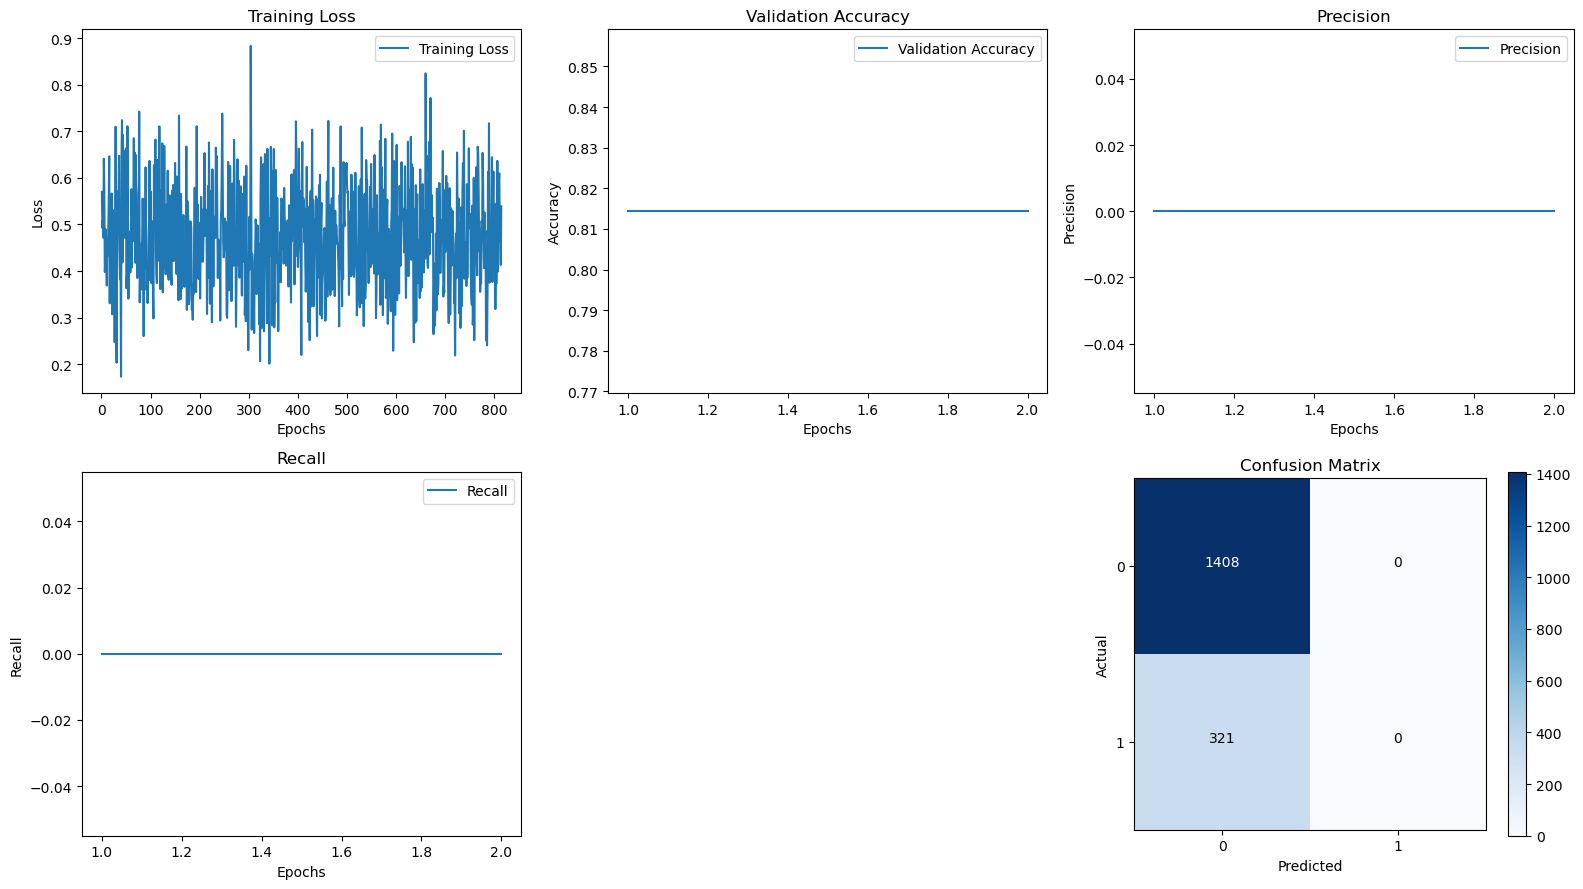

In [141]:
plot_metrics()

### 4. Apply the classifier to the test set

Lorem

In [144]:
test_dataset = CustomDataset(test_images, test_labels, target_size=image_shape)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Accuracy: 0.7961667173714634
Precision: 0.0
Recall: 0.0


/home/pape/micromamba/envs/main/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


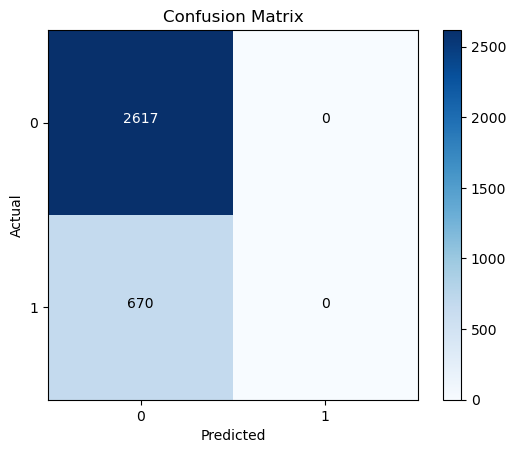

In [145]:
#
accuracy, precision, recall, confusion_matrix = evaluate_model(test_loader)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

plt.figure()
plot_confusion_matrix(confusion_matrix)
plt.show()